In [88]:
import optuna
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [89]:
# Cargar el dataset
data = pd.read_csv('electricity-consumption-processed.csv', sep=';', parse_dates=['datetime'])
data.set_index('datetime', inplace=True)

# Verificar los datos
print(data.head())

                    substation feeder  consumption
datetime                                          
2017-01-01 00:00:00          A     A1    64.671363
2017-01-01 01:00:00          A     A1    58.000000
2017-01-01 02:00:00          A     A1    58.000000
2017-01-01 03:00:00          A     A1    58.000000
2017-01-01 04:00:00          A     A1    52.000000


In [90]:
# Cargar covariantes
covariates = pd.read_csv('meteorological-processed.csv', sep=';', parse_dates=['datetime'])
covariates.set_index('datetime', inplace=True)
# Verificar los datos de las covariantes
print(covariates.head())

                     temperature   humidity  wind_speed    pressure
datetime                                                           
2017-01-01 00:00:00    26.000000  85.000000    9.300000  982.500000
2017-01-01 01:00:00    25.666667  88.000000    8.666667  982.266667
2017-01-01 02:00:00    25.333333  91.000000    8.033333  982.033333
2017-01-01 03:00:00    25.000000  94.000000    7.400000  981.800000
2017-01-01 04:00:00    24.000000  93.333333    9.866667  981.633333


In [91]:
# Agrupar por día y calcular el consumo máximo
daily_max_consumption = data.groupby(data.index.date)['consumption'].max().reset_index()
daily_max_consumption.columns = ['date', 'max_consumption']
daily_max_consumption.set_index('date', inplace=True)
print(daily_max_consumption)
# Agrupar las covariantes por día, usando la media como ejemplo
daily_covariates = covariates.groupby(covariates.index.date).mean()
daily_covariates.index = pd.to_datetime(daily_covariates.index)
daily_covariates = daily_covariates.reindex(daily_max_consumption.index)
print(daily_covariates)

            max_consumption
date                       
2017-01-01         322.4248
2017-01-02         345.0000
2017-01-03         375.0000
2017-01-04         377.0000
2017-01-05         336.0000
...                     ...
2020-12-27              NaN
2020-12-28              NaN
2020-12-29              NaN
2020-12-30              NaN
2020-12-31              NaN

[1461 rows x 1 columns]
            temperature   humidity  wind_speed    pressure
date                                                      
2017-01-01    26.308333  87.375000   12.000000  983.133333
2017-01-02    27.241667  79.125000    4.633333  982.704167
2017-01-03    27.908333  76.333333   10.191667  980.250000
2017-01-04    29.008333  75.666667   15.441667  979.908333
2017-01-05    26.000000  83.291667   12.704167  982.587500
...                 ...        ...         ...         ...
2020-12-27    26.683333  69.041667    8.625000  981.779167
2020-12-28    26.375000  79.208333   10.083333  982.033333
2020-12-29    26.3375

In [92]:

def forecast_energy(data, covariates, substation, feeder, train_start_date, train_end_date, test_start_date, test_end_date, n_trials):
    """
    Realiza una predicción de consumo energético utilizando SARIMAX para una subestación y alimentador específicos.
    
    Parámetros:
        data (DataFrame): Datos de consumo energético con columnas ['substation', 'feeder', 'consumption'] y un índice de fechas.
        covariates (DataFrame): Datos de las covariables con un índice de fechas.
        substation (str): Nombre de la subestación.
        feeder (str): Nombre del alimentador.
        train_start_date (str): Fecha de inicio del periodo de entrenamiento.
        train_end_date (str): Fecha de fin del periodo de entrenamiento.
        test_start_date (str): Fecha de inicio del periodo de prueba.
        test_end_date (str): Fecha de fin del periodo de prueba.
        n_trials (int): Número de iteraciones para la optimización con Optuna.

    Retorna:
        dict: Métricas de evaluación, mejores parámetros y predicciones.
    """
    # Filtrar los datos por subestación y alimentador
    data_filtered = data[(data['substation'] == substation) & (data['feeder'] == feeder)]
    data_filtered = data_filtered[train_start_date:test_end_date]

    # Agrupar por día y calcular el consumo máximo
    daily_max_consumption = data_filtered.groupby(data_filtered.index.date)['consumption'].max().reset_index()
    daily_max_consumption.columns = ['date', 'max_consumption']
    daily_max_consumption.set_index('date', inplace=True)

    # Asegurar que las covariantes están alineadas con los índices
    daily_covariates = covariates.reindex(daily_max_consumption.index)

    # Rellenar valores nulos si es necesario
    daily_max_consumption = daily_max_consumption.fillna(method='ffill').fillna(method='bfill')
    daily_covariates = daily_covariates.fillna(method='ffill').fillna(method='bfill')

    # Convertir los índices a tipo Timestamp
    daily_max_consumption.index = pd.to_datetime(daily_max_consumption.index)
    daily_covariates.index = pd.to_datetime(daily_covariates.index)

    # Dividir los datos en entrenamiento y prueba
    train_data = daily_max_consumption[train_start_date:train_end_date]
    test_data = daily_max_consumption[test_start_date:test_end_date]

    train_covariates = daily_covariates[train_start_date:train_end_date]
    test_covariates = daily_covariates[test_start_date:test_end_date]

    # Función objetivo para Optuna
    def objective(trial):
        p = trial.suggest_int("p", 0, 10)
        d = trial.suggest_int("d", 0, 2)
        q = trial.suggest_int("q", 0, 10)
        P = trial.suggest_int("P", 0, 2)
        D = trial.suggest_int("D", 0, 1)
        Q = trial.suggest_int("Q", 0, 2)
        m = trial.suggest_int("m", 7, 30)

        try:
            # Ajustar el modelo SARIMAX
            model = SARIMAX(
                train_data['max_consumption'],
                exog=train_covariates,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m)
            )
            results = model.fit(disp=False)

            # Predicciones en el periodo de prueba
            pred = results.get_prediction(
                start=test_data.index[0],
                end=test_data.index[-1],
                exog=test_covariates
            )
            pred_mean = pred.predicted_mean

            # Calcular MSE en el periodo de prueba
            mse = mean_squared_error(test_data['max_consumption'], pred_mean)
            return mse
        except Exception as e:
            print(f"Error en combinación de parámetros: {e}")
            return float('inf')

    # Optimización con Optuna
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials, n_jobs=-1)

    # Mejores parámetros encontrados
    best_params = study.best_params

    # Ajustar el modelo con los mejores parámetros
    model = SARIMAX(
        train_data['max_consumption'],
        exog=train_covariates,
        order=(best_params['p'], best_params['d'], best_params['q']),
        seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], best_params['m'])
    )
    results = model.fit()

    # Predicciones finales
    forecast = results.get_prediction(
        start=test_data.index[0],
        end=test_data.index[-1],
        exog=test_covariates
    )
    pred_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()

    # Calcular métricas finales
    mae = mean_absolute_error(test_data['max_consumption'], pred_mean)
    rmse = np.sqrt(mean_squared_error(test_data['max_consumption'], pred_mean))

    # Resultados
    results_dict = {
        "substation": substation,
        "feeder": feeder,
        "best_params": best_params,
        "mae": mae,
        "rmse": rmse,
        "pred_mean": pred_mean,
        "conf_int": conf_int
    }

    return results_dict



In [93]:
def plot_forecast_results(results, test_data, raw_data, feeder):
    """
    Genera gráficos de predicciones, datos crudos y distribuciones de consumos reales y predichos.
    
    Parámetros:
        results (dict): Resultados de la predicción, incluyendo 'pred_mean'.
        test_data (DataFrame): Datos reales del periodo de prueba (procesados).
        raw_data (DataFrame): Datos reales del periodo de prueba (crudos, sin agrupar).
        feeder (str): Nombre del alimentador.
    """
    # Gráfico de Predicción vs Consumo Real (máximo diario) vs Datos Crudos
    plt.figure(figsize=(12, 8))
    plt.plot(results['pred_mean'], label='Predicción', linestyle='--', color='green', alpha=0.7)
    plt.plot(test_data, label='Consumo Real (máximo diario)', color='blue', linewidth=2)
    plt.plot(raw_data['consumption'], label='Datos Crudos', color='gray', alpha=0.5)

    plt.xlabel('Fecha')
    plt.ylabel('Consumo de Energía (kWh)')
    plt.title(f'Consumo Real vs Predicción vs Datos Crudos - Alimentador {feeder}')
    plt.legend()
    plt.grid()
    plt.show()

    

    # Crear el histograma de los errores
    errors2 = (test_data) - (results['pred_mean'])
    plt.figure(figsize=(10, 6))
    plt.hist(errors2, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Histograma de Errores')
    plt.xlabel('Error (Predicción - Real)')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

In [94]:
# Realizar predicción para el alimentador B1
results_b1 = forecast_energy(
    data=data,
    covariates=daily_covariates,
    substation='B',
    feeder='B1',
    train_start_date='2018-03-01',
    train_end_date='2019-04-30',
    test_start_date='2019-05-01',
    test_end_date='2019-05-30',
    n_trials=2
)



C:\Users\loku7\AppData\Local\Temp\ipykernel_9316\2264937299.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_max_consumption = daily_max_consumption.fillna(method='ffill').fillna(method='bfill')
C:\Users\loku7\AppData\Local\Temp\ipykernel_9316\2264937299.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_covariates = daily_covariates.fillna(method='ffill').fillna(method='bfill')
[I 2024-12-18 22:49:33,423] A new study created in memory with name: no-name-5348d085-343e-47b9-9adf-ac8aee148f33
C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C

                    substation feeder  consumption
datetime                                          
2019-05-01 00:00:00          B     B1        125.0
2019-05-01 01:00:00          B     B1        125.0
2019-05-01 02:00:00          B     B1        125.0
2019-05-01 03:00:00          B     B1        125.0
2019-05-01 04:00:00          B     B1        110.0
...                        ...    ...          ...
2019-05-30 19:00:00          B     B1        160.0
2019-05-30 20:00:00          B     B1        143.0
2019-05-30 21:00:00          B     B1        122.0
2019-05-30 22:00:00          B     B1        133.0
2019-05-30 23:00:00          B     B1        106.0

[720 rows x 3 columns]
2019-05-01    161.290359
2019-05-02    280.000000
2019-05-03    287.000000
2019-05-04    234.000000
2019-05-05    182.000000
2019-05-06    262.000000
2019-05-07    258.000000
2019-05-08    284.000000
2019-05-09    253.000000
2019-05-10    276.000000
2019-05-11    216.000000
2019-05-12    154.658456
2019-05-13   

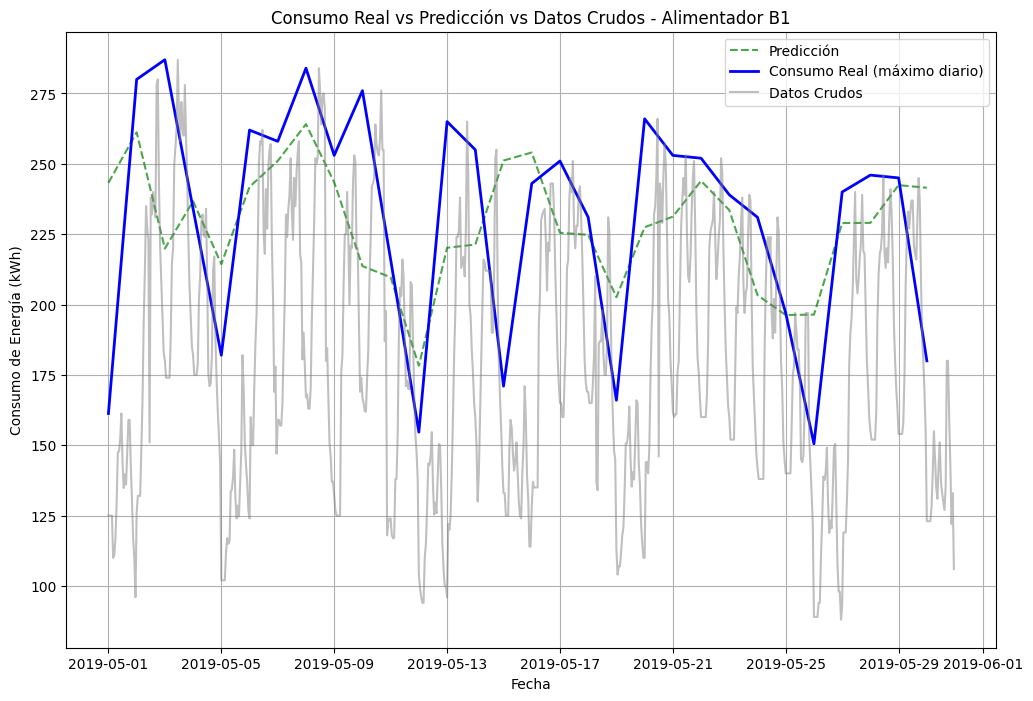

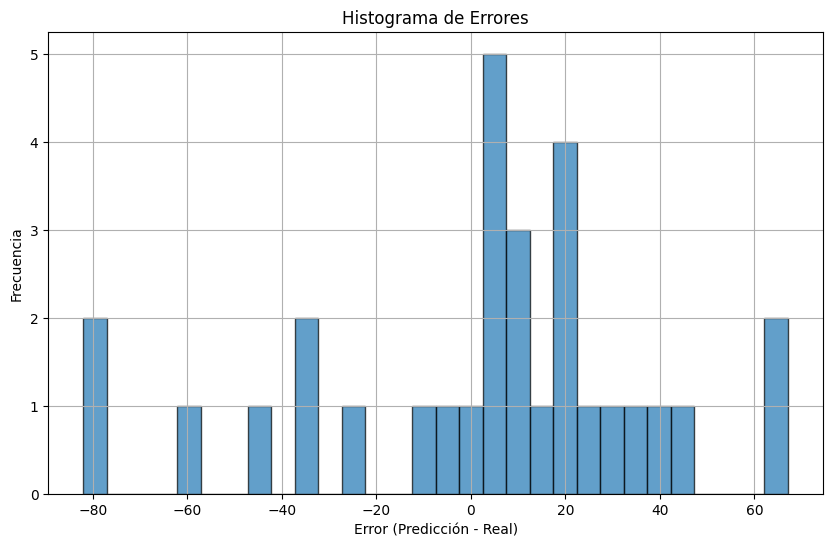

In [95]:
# Extraer los datos reales procesados (máximo diario)
test_data_b1 = data[(data['substation'] == 'B') & (data['feeder'] == 'B1')]
test_data_b1 = test_data_b1.loc['2019-05-01':'2019-05-30']
test_data_b1_daily = test_data_b1.groupby(test_data_b1.index.date)['consumption'].max()
print(test_data_b1)
test_data_b1 = pd.to_datetime(test_data_b1.index)


#test_data_b1_daily = pd.DataFrame(test_data_b1_daily, columns=['max_consumption'])
print(test_data_b1_daily)
# Extraer los datos reales crudos
raw_data_b1 = data[(data['substation'] == 'B') & (data['feeder'] == 'B1')]
raw_data_b1 = raw_data_b1['2019-05-01':'2019-05-30']
# Graficar resultados para el alimentador B1
plot_forecast_results(results_b1, test_data_b1_daily, raw_data_b1, feeder='B1')

In [96]:
# Realizar predicción para el alimentador B1
results_b1 = forecast_energy(
    data=data,
    covariates=daily_covariates,
    substation='B',
    feeder='B2',
    train_start_date='2018-03-01',
    train_end_date='2019-04-30',
    test_start_date='2019-05-01',
    test_end_date='2019-05-30',
    n_trials=2
)


C:\Users\loku7\AppData\Local\Temp\ipykernel_9316\2264937299.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_max_consumption = daily_max_consumption.fillna(method='ffill').fillna(method='bfill')
C:\Users\loku7\AppData\Local\Temp\ipykernel_9316\2264937299.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_covariates = daily_covariates.fillna(method='ffill').fillna(method='bfill')
[I 2024-12-18 22:49:46,620] A new study created in memory with name: no-name-9db97165-27b0-47f4-80e8-a062e854e2e6
C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C

                    substation feeder  consumption
datetime                                          
2019-05-01 00:00:00          B     B2         39.0
2019-05-01 01:00:00          B     B2         34.0
2019-05-01 02:00:00          B     B2         34.0
2019-05-01 03:00:00          B     B2         34.0
2019-05-01 04:00:00          B     B2         46.0
...                        ...    ...          ...
2019-05-30 19:00:00          B     B2         50.0
2019-05-30 20:00:00          B     B2         40.0
2019-05-30 21:00:00          B     B2         34.0
2019-05-30 22:00:00          B     B2         32.0
2019-05-30 23:00:00          B     B2         32.0

[720 rows x 3 columns]
2019-05-01    100.0
2019-05-02    115.0
2019-05-03    115.0
2019-05-04    101.0
2019-05-05    107.0
2019-05-06    108.0
2019-05-07    111.0
2019-05-08    114.0
2019-05-09    110.0
2019-05-10    122.0
2019-05-11     99.0
2019-05-12     78.0
2019-05-13    102.0
2019-05-14    109.0
2019-05-15    101.0
2019-05-16   

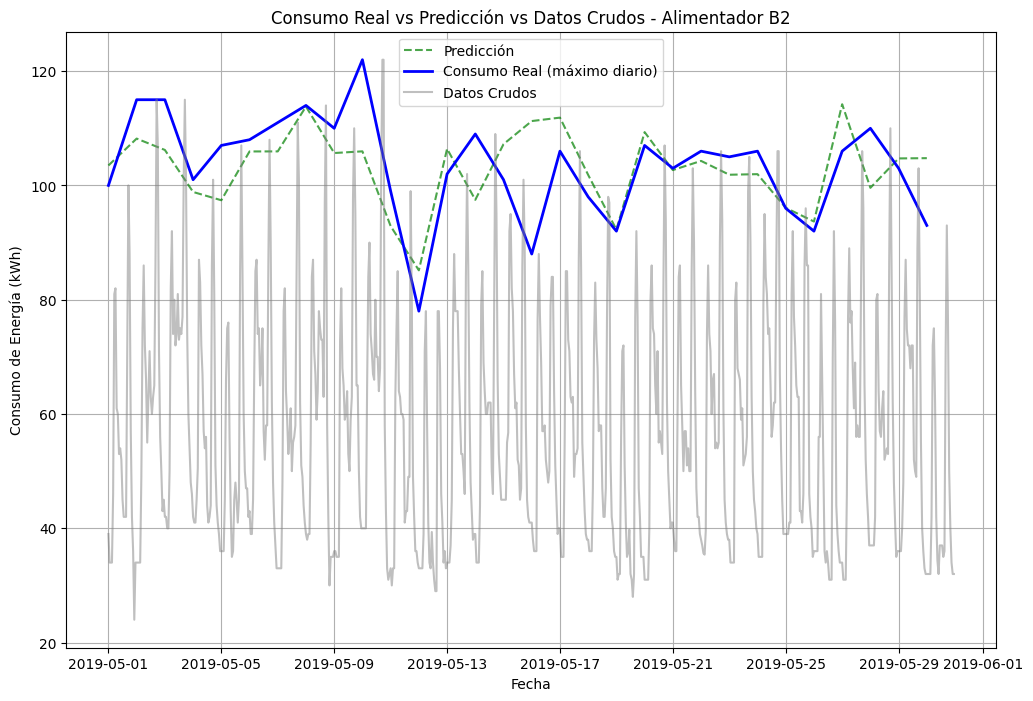

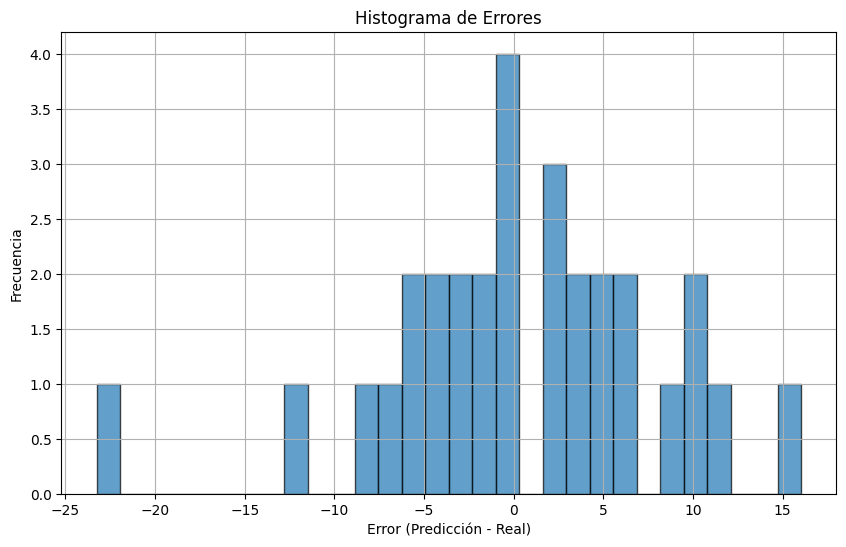

In [97]:
# Extraer los datos reales procesados (máximo diario)
test_data_b1 = data[(data['substation'] == 'B') & (data['feeder'] == 'B2')]
test_data_b1 = test_data_b1.loc['2019-05-01':'2019-05-30']
test_data_b1_daily = test_data_b1.groupby(test_data_b1.index.date)['consumption'].max()
print(test_data_b1)
test_data_b1 = pd.to_datetime(test_data_b1.index)


#test_data_b1_daily = pd.DataFrame(test_data_b1_daily, columns=['max_consumption'])
print(test_data_b1_daily)
# Extraer los datos reales crudos
raw_data_b1 = data[(data['substation'] == 'B') & (data['feeder'] == 'B2')]
raw_data_b1 = raw_data_b1['2019-05-01':'2019-05-30']
# Graficar resultados para el alimentador B2
plot_forecast_results(results_b1, test_data_b1_daily, raw_data_b1, feeder='B2')

In [98]:
# Realizar predicción para el alimentador B3
results_b1 = forecast_energy(
    data=data,
    covariates=daily_covariates,
    substation='B',
    feeder='B3',
    train_start_date='2018-03-01',
    train_end_date='2019-04-30',
    test_start_date='2019-05-01',
    test_end_date='2019-05-30',
    n_trials=2
)


C:\Users\loku7\AppData\Local\Temp\ipykernel_9316\2264937299.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_max_consumption = daily_max_consumption.fillna(method='ffill').fillna(method='bfill')
C:\Users\loku7\AppData\Local\Temp\ipykernel_9316\2264937299.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_covariates = daily_covariates.fillna(method='ffill').fillna(method='bfill')
[I 2024-12-18 22:50:31,205] A new study created in memory with name: no-name-c2e8a4b6-ddca-426e-b66f-67e7ecce4c9f
C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C

                    substation feeder  consumption
datetime                                          
2019-05-01 00:00:00          B     B3         28.0
2019-05-01 01:00:00          B     B3         25.0
2019-05-01 02:00:00          B     B3         25.0
2019-05-01 03:00:00          B     B3         25.0
2019-05-01 04:00:00          B     B3         25.0
...                        ...    ...          ...
2019-05-30 19:00:00          B     B3         21.0
2019-05-30 20:00:00          B     B3         21.0
2019-05-30 21:00:00          B     B3         21.0
2019-05-30 22:00:00          B     B3         22.0
2019-05-30 23:00:00          B     B3         18.0

[720 rows x 3 columns]
2019-05-01     44.015911
2019-05-02     97.000000
2019-05-03    101.000000
2019-05-04     89.000000
2019-05-05     44.537901
2019-05-06     99.000000
2019-05-07     91.000000
2019-05-08    103.000000
2019-05-09     74.000000
2019-05-10     91.000000
2019-05-11     80.000000
2019-05-12     41.583085
2019-05-13   

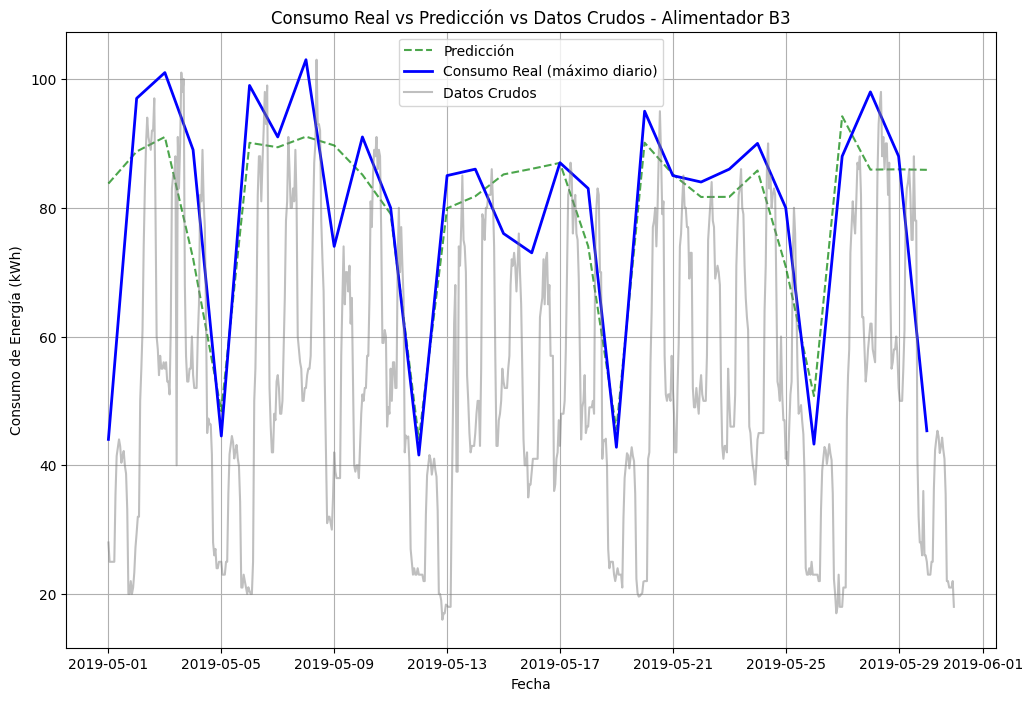

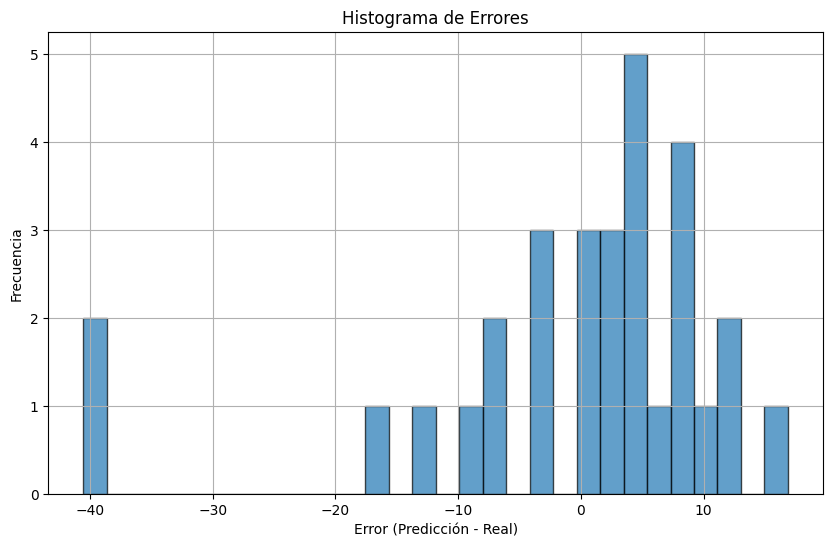

In [99]:
# Extraer los datos reales procesados (máximo diario)
test_data_b1 = data[(data['substation'] == 'B') & (data['feeder'] == 'B3')]
test_data_b1 = test_data_b1.loc['2019-05-01':'2019-05-30']
test_data_b1_daily = test_data_b1.groupby(test_data_b1.index.date)['consumption'].max()
print(test_data_b1)
test_data_b1 = pd.to_datetime(test_data_b1.index)


#test_data_b1_daily = pd.DataFrame(test_data_b1_daily, columns=['max_consumption'])
print(test_data_b1_daily)
# Extraer los datos reales crudos
raw_data_b1 = data[(data['substation'] == 'B') & (data['feeder'] == 'B3')]
raw_data_b1 = raw_data_b1['2019-05-01':'2019-05-30']
# Graficar resultados para el alimentador B2
plot_forecast_results(results_b1, test_data_b1_daily, raw_data_b1, feeder='B3')

In [100]:
# Realizar predicción para el alimentador B4
results_b1 = forecast_energy(
    data=data,
    covariates=daily_covariates,
    substation='B',
    feeder='B4',
    train_start_date='2018-03-01',
    train_end_date='2019-04-30',
    test_start_date='2019-05-01',
    test_end_date='2019-05-30',
    n_trials=2
)


C:\Users\loku7\AppData\Local\Temp\ipykernel_9316\2264937299.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_max_consumption = daily_max_consumption.fillna(method='ffill').fillna(method='bfill')
C:\Users\loku7\AppData\Local\Temp\ipykernel_9316\2264937299.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_covariates = daily_covariates.fillna(method='ffill').fillna(method='bfill')
[I 2024-12-18 22:52:01,476] A new study created in memory with name: no-name-df10d977-0127-46dc-93a7-19aaa94805fa
C:\Users\loku7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C

                    substation feeder  consumption
datetime                                          
2019-05-01 00:00:00          B     B4         99.0
2019-05-01 01:00:00          B     B4        104.0
2019-05-01 02:00:00          B     B4        104.0
2019-05-01 03:00:00          B     B4        104.0
2019-05-01 04:00:00          B     B4        104.0
...                        ...    ...          ...
2019-05-30 19:00:00          B     B4        201.0
2019-05-30 20:00:00          B     B4        190.0
2019-05-30 21:00:00          B     B4        170.0
2019-05-30 22:00:00          B     B4        153.0
2019-05-30 23:00:00          B     B4        141.0

[720 rows x 3 columns]
2019-05-01    160.438896
2019-05-02    277.000000
2019-05-03    279.000000
2019-05-04    234.000000
2019-05-05    161.000000
2019-05-06    263.000000
2019-05-07    264.000000
2019-05-08    273.000000
2019-05-09    268.000000
2019-05-10    270.000000
2019-05-11    234.000000
2019-05-12    150.005706
2019-05-13   

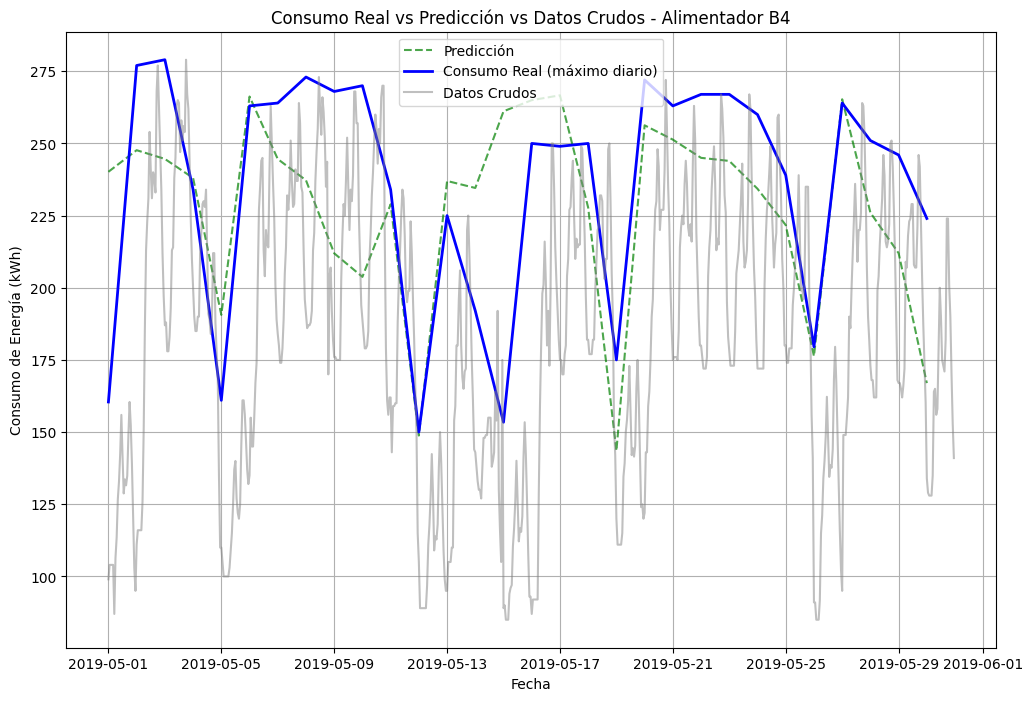

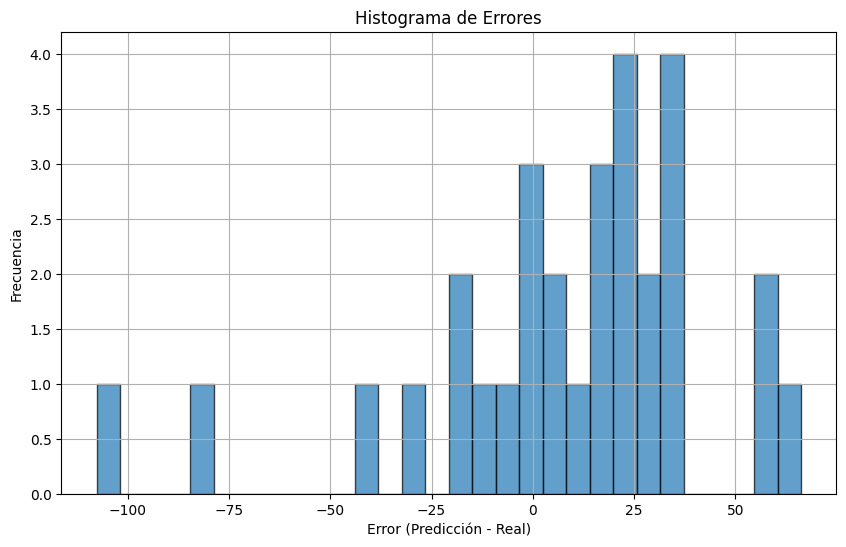

In [101]:
# Extraer los datos reales procesados (máximo diario)
test_data_b1 = data[(data['substation'] == 'B') & (data['feeder'] == 'B4')]
test_data_b1 = test_data_b1.loc['2019-05-01':'2019-05-30']
test_data_b1_daily = test_data_b1.groupby(test_data_b1.index.date)['consumption'].max()
print(test_data_b1)
test_data_b1 = pd.to_datetime(test_data_b1.index)


#test_data_b1_daily = pd.DataFrame(test_data_b1_daily, columns=['max_consumption'])
print(test_data_b1_daily)
# Extraer los datos reales crudos
raw_data_b1 = data[(data['substation'] == 'B') & (data['feeder'] == 'B4')]
raw_data_b1 = raw_data_b1['2019-05-01':'2019-05-30']
# Graficar resultados para el alimentador B4
plot_forecast_results(results_b1, test_data_b1_daily, raw_data_b1, feeder='B4')